In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,precision_score,recall_score
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 6



use_cols = ['airline_sentiment', 'text', 'airline']
df=pd.read_csv('Tweets.csv', usecols=use_cols)
df.head(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   airline            14640 non-null  object
 2   text               14640 non-null  object
dtypes: object(3)
memory usage: 343.2+ KB


**DATA CLEANING AND TEXT PRE-PROCESSING**

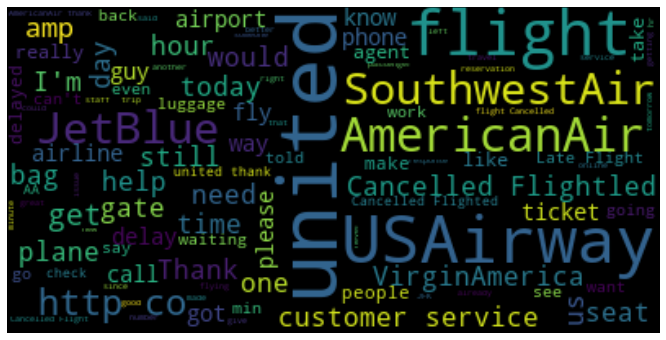

In [4]:
# exploratory analysis

from wordcloud import WordCloud

new_text = " ".join(text for text in df.text)


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black", stopwords=stopwords.words("english")).generate(new_text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    #some words might give us something important for the sentiment analysis like not, so we keep them
    wl = ["not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in wl) and len(word) > 1] 
    return " ".join(clean_words)

def remove_mentions(input_text):
    for i in range(len(input_text)):
        input_text[i] = re.sub(r'@\w+', '', input_text[i])
    return input_text

def lower_case(input_text):
    for i in range(len(input_text)):
              input_text[i] = input_text[i].lower()
    return input_text

def remove_http(input_text):
    for i in range(len(input_text)):
        input_text[i] = re.sub(r'http\S+', '',input_text[i])
    return input_text

def remove_punctuation(input_text):
    for i in range(len(input_text)):
        input_text[i] = re.sub(r'[^\w\s]','',input_text[i])
    return input_text

In [6]:
# Applying the functions above

new_data = df[['text', 'airline_sentiment']]
preprocessed_data = new_data.apply(remove_mentions).apply(remove_http).apply(remove_punctuation).apply(lower_case)
clean_text = []
for tweet in preprocessed_data.text:
    clean = remove_stopwords(tweet)
    clean_text.append(clean)

X = clean_text
Y = preprocessed_data['airline_sentiment']
from sklearn.model_selection import train_test_split
Y = Y.map({'negative':0, 'positive':1, 'neutral':2}).astype(int)
X_train,X_test,y_train,y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [7]:
# Word representation using word2vec

from gensim.models import Word2Vec
sentences = [line.split() for line in clean_text]
w2v = Word2Vec(sentences, size=50, min_count = 0, window = 5,workers=4,iter=500)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


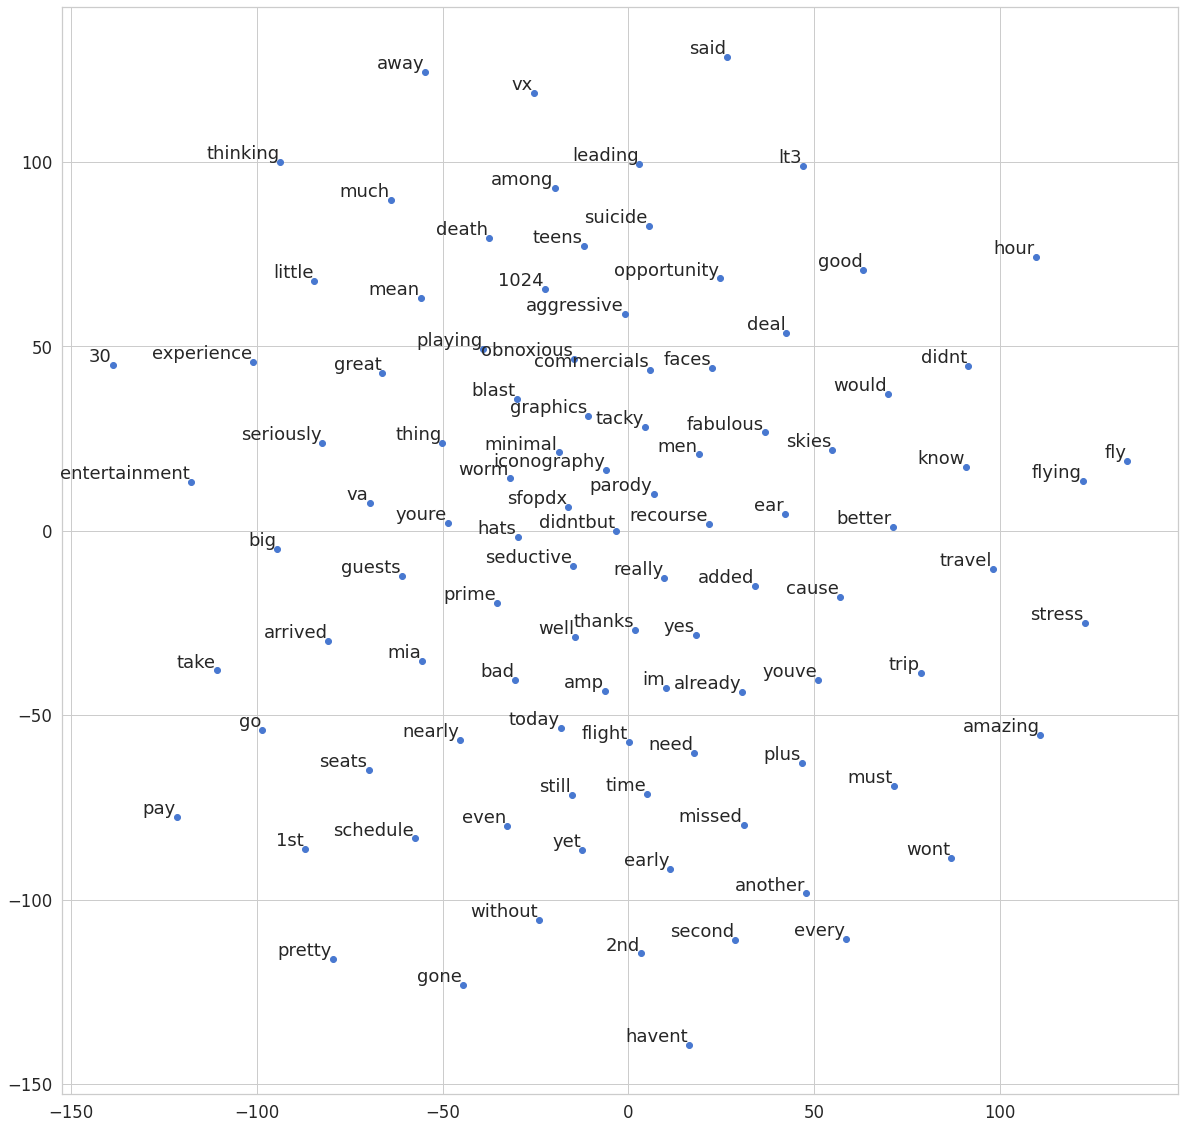

In [8]:
# visualization of what word2vec learned
# visualization of what word2vec actually learn, you can notice that words that are similar are actually close in the space.
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X = w2v[w2v.wv.vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X[0:100])
plt.rcParams["figure.figsize"] = (20,20)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
labels = list(w2v.wv.vocab.keys())
for label, x, y in zip(labels, X_tsne[:, 0], X_tsne[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-1, -1),
        textcoords='offset points', ha='right', va='bottom')

plt.show()

In [9]:
# For deep learning techniques, every word should be replaced by a token, and stored in a dictionary that holds for every word its embeddings.
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

t = Tokenizer()
t.fit_on_texts(clean_text)
vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(clean_text)
padded_docs = pad_sequences(encoded_docs, maxlen=20, padding='post')
embedding_dict = dict()
for i in w2v.wv.vocab:
    embedding_dict[i] = w2v[i]

embedding_matrix = np.zeros((vocab_size, 50))
for word, i in t.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [10]:
# At first, the labels should be in the form of one hot encoders.

import tensorflow as tf
y_one_hot = tf.keras.utils.to_categorical(
    Y,
    num_classes=3,
    dtype='int32'
)


In [11]:
def results(labels, pred):
  print(confusion_matrix(labels,pred))  
  print('accuracy',accuracy_score(labels,pred))
  print('recall',recall_score(labels,pred,average='weighted'))
  print('precision',precision_score(labels,pred,average='weighted'))


In [12]:
x_train_DL, x_test_DL,y_train_DL,y_test_DL = train_test_split(padded_docs,y_one_hot,test_size=0.1,random_state=42)


**BUILDING DEEP LEARNING MODEL(CNN)**

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Embedding,LSTM, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from sklearn.metrics import accuracy_score
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras.layers import Dropout

model = Sequential()
embedding_layer = Embedding(vocab_size,50,embeddings_initializer = Constant(embedding_matrix),input_length=20, trainable=False)
model.add(embedding_layer)
model.add(Convolution1D(filters=100, kernel_size=5, strides=1, padding="valid",activation='relu',data_format='channels_last', dilation_rate=1, groups=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(128,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax'))
print(model.summary())
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(x_train_DL,y_train_DL,
                    validation_data=(x_test_DL, y_test_DL),
                    epochs=20)
ans = model.predict(x_test_DL)
labels = [np.where(r==1)[0][0] for r in y_test_DL]
ans = np.argmax(ans,axis=1)

results(ans,labels)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 50)            726400    
                                                                 
 conv1d (Conv1D)             (None, 16, 100)           25100     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               12928     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                        

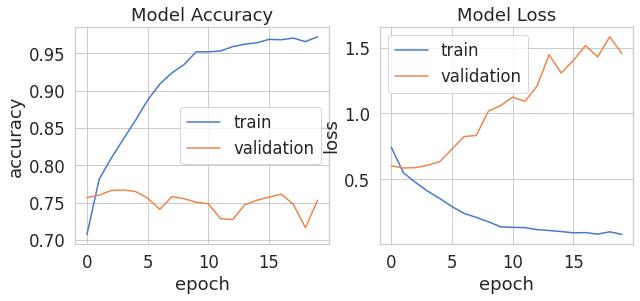

In [14]:
def plot_training_hist(history):
  '''Function to plot history for accuracy and loss'''
  
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  # first plot
  #print(history.history)
  ax[0].plot(history.history['accuracy'])
  ax[0].plot(history.history['val_accuracy'])
  ax[0].set_title('Model Accuracy')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('accuracy')
  ax[0].legend(['train', 'validation'], loc='best')
  # second plot
  ax[1].plot(history.history['loss'])
  ax[1].plot(history.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('loss')
  ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

**DEEP LEARNING MODEL (LSTM)**

In [15]:
model = Sequential() 
embedding_layer = Embedding(vocab_size,50,embeddings_initializer = Constant(embedding_matrix),input_length=20, trainable=True)
model.add(embedding_layer)
model.add(LSTM(32, activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation = 'softmax'))
print(model.summary())
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history2= model.fit(x_train_DL,y_train_DL,epochs = 20,validation_data=(x_test_DL, y_test_DL),batch_size=256)
ans = model.predict(x_test_DL)
labels = [np.where(r==1)[0][0] for r in y_test_DL]
ans = np.argmax(ans,axis=1)

results(ans,labels)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 50)            726400    
                                                                 
 lstm (LSTM)                 (None, 20, 32)            10624     
                                                                 
 dropout_1 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 745,443
Trainable params: 745,443
Non-tr

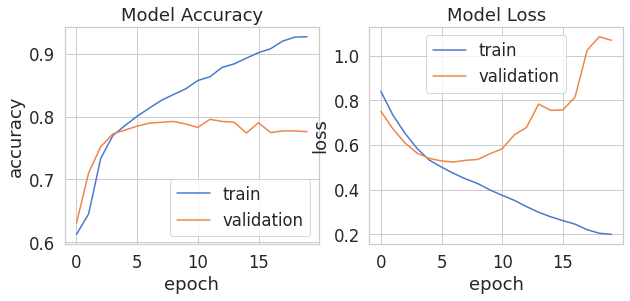

In [16]:
def plot_training_hist(history):
  '''Function to plot history for accuracy and loss'''
  
  fig, ax = plt.subplots(1, 2, figsize=(10,4))
  # first plot
  #print(history.history)
  ax[0].plot(history2.history['accuracy'])
  ax[0].plot(history2.history['val_accuracy'])
  ax[0].set_title('Model Accuracy')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('accuracy')
  ax[0].legend(['train', 'validation'], loc='best')
  # second plot
  ax[1].plot(history2.history['loss'])
  ax[1].plot(history2.history['val_loss'])
  ax[1].set_title('Model Loss')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('loss')
  ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history2)